In [48]:
import string
from datetime import datetime
from functools import wraps
from pathlib import Path

import nltk
import numpy as np
from nltk import sent_tokenize, word_tokenize, PorterStemmer
from nltk.corpus import stopwords
from nltk.stem.api import StemmerI
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\calga\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\calga\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
def print_dict_ordered_on_keys(d: dict, reverse: bool = True) -> None:
    """
    Prints a dictionary ordered based on the keys

    Args:
        d: the dictionary to predict
        reverse: a flag to say whether to reverse the sort or not

    Returns:
        None
    """
    print({term: frequency for term, frequency in sorted(d.items(), key=lambda x: x[1], reverse=reverse)})

In [3]:
def log_time(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = datetime.now()
        result = func(*args, **kwargs)
        end_time = datetime.now()
        total_time = end_time - start_time
        print(f'Function {func.__name__} Took {total_time}')
        return result

    return timeit_wrapper

In [4]:
with open(
        "../../../FilestoreRepo/FTSE100Info/txtReports/3i_group/20220628_JP_Morgan_III-LN_3i-_Exclusive_talks_to_sell_Havea_with_proceeds_expected.tei.xml.txt",
        "r", encoding="utf-8") as f:
    document = f.read()
print(document)


Europe Equity Research
23 Jun 2022
/J PMorgan
ChristopherBrown
christopher.brown@jpmorgan.com
CFAAdamKelly
adam.kelly@jpmorgan.com
JP MorganSecurities
LiamMacdonald-Raggett -Sales
JPMorgan
Investment Companies
UK
Investment Industry Regulatory Organization
Canada
Europe Equity Research
23 Jun 2022
37FDCB7B9D122FDA48C78B46395D668F
GROBID - A machine learning software for extracting information from scholarly documents
J.P. Morgan does and seeks to do business with companies covered in its research reports. As a result, investors should be aware that the firm may have a conflict of interest that could affect the objectivity of this report. Investors should consider this report as only a single factor in making their investment decision.
3i has announced that it, and its co-investor Cathay Capital, has entered into exclusive negotiations to sell Havea Group to BC Partners, alongside Havea's management team. Closing is expected in Q4 22 and proceeds are expected to be at around a 50% upli

In [5]:
# Replace all punctuation with white space and make lower case
document = "".join([" " if t in string.punctuation else t for t in document]).lower()

In [6]:
# Split into tokens
doc_tokens = set(word_tokenize(document))
print(doc_tokens)

{'single', 'updated', 'chart', '093', 'firms', 'factors', 'last', 'simultaneously', 'www', 'views', 'become', 'necessary', 'expected', 'seen', 'firm', 'valuation', 'download', 'report', '25', 'nor', 'during', 'consider', 'indirectly', 'brought', 'mumbai', 'factor', 'those', 'removed', 'specifically', 'reliance', 'explanation', 'related', 'trades', 'brazil', 'derivatives', 'close', 'license', 'morgan', 'over', 'down', '16', 'per', 'similarly', '£196m', 'monetary', 'bureau', 'updates', 'jurisdiction', 'accurately', 'hedging', 'question', 'coverage', 'noted', 'board', 'de', 'cfaadamkelly', 'governmental', 'ensure', 'earnings', 'australia', 'preceding', 'please', 'securitiesmorgan', 'certify', 'advertisement', 'registration', 'warrants', '10', 'associated', 'trustees', 'industry', 'more', 'bank', 'completeness', 'calculations', 'structured', '37fdcb7b9d122fda48c78b46395d668f', 'may', 'they', '2021', 'than', 'gross', 'following', 'authorised', 'flat', 'communications', 'macau', 'facilitatin

In [7]:
print(len(doc_tokens))

941


In [8]:
ps = PorterStemmer()
doc_tokens = {ps.stem(doc_token) for doc_token in doc_tokens}
# print(doc_tokens)
print(len(doc_tokens))

799


In [9]:
doc_tokens = {doc_token for doc_token in doc_tokens if doc_token not in stopwords.words("english")}
print(len(doc_tokens))
# print(doc_tokens)

733


In [10]:
def preprocess_text(text_or_filepath: str | Path, stemmer: StemmerI = PorterStemmer(), as_list: bool = False) -> \
    list[str] |set[str]:
    """
    Pre-processes text by:
        removing punctuation
        tokenizing the string
        removing stop words
        stemming tokens to common roots

    Args:
        text_or_filepath: the text or the filepath to the file containing the text to run pre-processing on
        stemmer: the stemmer to use if not given a default stemmer of the nltk.stem.porter.PorterStemmer is used
        as_list: if true will calculate and return values as a list else will calculate and return as a set

    Returns:
        Either a list or a set of all pre-processed tokens in the text
        If a list it will have the number of duplicate terms as occur in the text
    """
    if isinstance(text_or_filepath, Path):
        if not text_or_filepath.is_file():
            print(f"filepath {text_or_filepath.resolve()} doesn't point to a file")
        with open(text_or_filepath, "r", encoding="utf-8") as f:
            text = f.read()
    else:
        text = text_or_filepath

    # Replace all punctuation with white space and make lower case
    text = "".join([" " if t in string.punctuation else t for t in text]).lower()
    if as_list:
        # Return tokens as a list
        # Split into tokens
        doc_tokens = word_tokenize(text)
        # Remove Stopwords
        doc_tokens = [doc_token for doc_token in doc_tokens if doc_token not in stopwords.words("english")]
        # Stem Tokens
        doc_tokens = [stemmer.stem(doc_token) for doc_token in doc_tokens]
    else:
        # Return tokens as a set
        # Split into tokens
        doc_tokens = set(word_tokenize(text))
        # Remove Stopwords
        doc_tokens = {doc_token for doc_token in doc_tokens if doc_token not in stopwords.words("english")}
        # Stem Tokens
        doc_tokens = {stemmer.stem(doc_token) for doc_token in doc_tokens}
    return doc_tokens

In [11]:
root_folder_path = Path("../../../FilestoreRepo/FTSE100Info/txtReports/3i_group")
term_doc_count = dict()
num_docs = 0
for filepath in root_folder_path.rglob("*.txt"):
    print(f"{filepath.resolve()}")
    if filepath.is_file():
        num_docs += 1
        with open(filepath, "r", encoding="utf-8") as f:
            document = f.read()
        doc_tokens = preprocess_text(document, as_list=False)
        for token in doc_tokens:
            if token in term_doc_count:
                term_doc_count[token] += 1
            else:
                term_doc_count[token] = 1

C:\Users\calga\Documents\gitHubRepos\FilestoreRepo\FTSE100Info\txtReports\3i_group\20220524_Barclays_III-LN_3i_Group_PLC-_Management_presentation_highlights_that_th.tei.xml.txt
C:\Users\calga\Documents\gitHubRepos\FilestoreRepo\FTSE100Info\txtReports\3i_group\20220525_JP_Morgan_III-LN_3i-_11-_fall_yesterday_on_poor_US_retail_sentiment_is_an.tei.xml.txt
C:\Users\calga\Documents\gitHubRepos\FilestoreRepo\FTSE100Info\txtReports\3i_group\20220607__-EGAN_JONES_on_3i_Group_plc.tei.xml.txt
C:\Users\calga\Documents\gitHubRepos\FilestoreRepo\FTSE100Info\txtReports\3i_group\20220628_JP_Morgan_III-LN_3i-_Exclusive_talks_to_sell_Havea_with_proceeds_expected.tei.xml.txt
C:\Users\calga\Documents\gitHubRepos\FilestoreRepo\FTSE100Info\txtReports\3i_group\20220706_JP_Morgan_III-LN_3i-_Portfolio_update_reassures_no_changes_to_estimates.tei.xml.txt
C:\Users\calga\Documents\gitHubRepos\FilestoreRepo\FTSE100Info\txtReports\3i_group\20220707_Barclays_III-LN_3i_Group_PLC-_AGM_statement_reiterates_portfolio_r

In [12]:
print(term_doc_count)

{'unwind': 1, 'subsequ': 7, 'notifi': 6, 'chart': 14, 'overweightamundi': 1, 'elig': 6, 'divert': 1, 'ratingoverweight': 6, 'limit': 15, 'financi': 14, 'strong': 11, 'promot': 11, 'last': 12, 'closur': 6, 'www': 15, 'place': 15, 'thu': 9, 'variou': 12, '29': 6, 'sdr': 6, 'howev': 7, 'entri': 3, 'diversifi': 6, 'lansdown': 6, 'mutual': 5, 'seen': 4, 'firm': 16, 'estim': 13, 'report': 16, '25': 10, '526': 6, 'extract': 16, 'mean': 7, 'base': 14, 'mumbai': 10, 'access': 16, 'factor': 15, 'middl': 5, 'fundament': 14, 'govern': 10, 'local': 12, 'therefor': 14, 'close': 14, 'descript': 7, '07': 7, 'trajectori': 2, 'much': 2, 'india': 13, 'complet': 14, 'right': 4, 'pricetarget': 6, 'gartenhau': 7, 'buy': 6, 'contain': 15, 'ashm': 6, 'disclaim': 6, 'finland': 6, 'government': 10, 'mandatori': 6, 'articl': 11, 'ku': 6, 'criteria': 6, 'island': 6, 'space': 1, 'treat': 6, 'excess': 2, '143': 6, 'fiduciari': 6, 'daisyxu': 5, 'partner': 7, 'countryinform': 5, 'board': 10, 'two': 4, 'reli': 15, 'de

In [13]:
idf = {term: np.log(num_docs / frequency) for term, frequency in term_doc_count.items()}

In [14]:
print_dict_ordered_on_keys(idf)

{'unwind': 2.772588722239781, 'overweightamundi': 2.772588722239781, 'divert': 2.772588722239781, 'space': 2.772588722239781, 'host': 2.772588722239781, 'topic': 2.772588722239781, 'nil': 2.772588722239781, 'positivebanca': 2.772588722239781, 'zaimukyokuchoasia': 2.772588722239781, 'fin': 2.772588722239781, 'itali': 2.772588722239781, 'aggress': 2.772588722239781, 'suit': 2.772588722239781, 'demograph': 2.772588722239781, 'meaning': 2.772588722239781, 'caution': 2.772588722239781, 'eurofund': 2.772588722239781, '1735': 2.772588722239781, 'restart': 2.772588722239781, 'surpris': 2.772588722239781, 'withdrawn': 2.772588722239781, '20provid': 2.772588722239781, 'salesforc': 2.772588722239781, 'situat': 2.772588722239781, '3914': 2.772588722239781, 'weaker': 2.772588722239781, 'pilot': 2.772588722239781, 'crisi': 2.772588722239781, '4338a27f44e32d6e7a0fd342f3cddc82': 2.772588722239781, 'sander': 2.772588722239781, 'justifi': 2.772588722239781, '45research': 2.772588722239781, 'audley': 2.7

In [15]:
test_file_path: Path = Path(
    "../../../FilestoreRepo/FTSE100Info/txtReports/3i_group/20220628_JP_Morgan_III-LN_3i-_Exclusive_talks_to_sell_Havea_with_proceeds_expected.tei.xml.txt")

with open(test_file_path, "r", encoding="utf-8") as f:
    test_document = f.read()

# Get the tokens from the test document
query_tokens: list = preprocess_text(test_document, as_list=True)

# Generate the unique list of words
unique_tokens = set(query_tokens)

wordcounts = {token: query_tokens.count(token) for token in unique_tokens}
print(wordcounts)

{'chart': 2, '093': 1, 'limit': 6, 'financi': 11, 'promot': 2, 'outcom': 1, 'last': 2, 'www': 4, 'place': 1, 'thu': 1, 'variou': 1, 'valor': 1, 'estim': 4, 'firm': 6, 'seen': 1, 'download': 1, 'report': 16, '25': 1, 'extract': 1, 'base': 4, 'brought': 1, 'mumbai': 1, 'access': 1, 'factor': 3, 'fundament': 2, 'govern': 1, 'brazil': 2, 'therefor': 1, 'close': 2, 'morgan': 34, 'consist': 1, '16': 1, 'per': 1, 'complet': 2, '£196m': 1, 'contain': 3, 'regim': 1, 'bureau': 1, 'government': 1, 'mobiliario': 1, 'articl': 3, 'materi': 40, 'partner': 1, 'question': 1, 'board': 1, 'explan': 1, 'reli': 3, 'de': 1, 'origin': 1, 'australia': 2, 'manag': 3, 'securitiesmorgan': 1, 'permit': 2, 'natur': 1, '10': 1, 'bank': 9, 'simultan': 1, '37fdcb7b9d122fda48c78b46395d668f': 1, 'may': 23, '2021': 1, 'navig': 1, 'gross': 1, 'revenu': 1, 'equiti': 7, 'flat': 1, 'obtain': 1, 'macau': 2, 'proprietari': 2, 'taiwan': 9, 'histori': 1, 'recent': 3, 'shown': 2, 'interest': 5, 'expect': 10, 'term': 3, 'key': 1,

In [16]:
tfidf = {term: frequency * idf[term] for term, frequency in wordcounts.items()}
print(tfidf)

{'chart': 0.26706278524904514, '093': 1.1631508098056809, 'limit': 0.387231126825427, 'financi': 1.4688453188697483, 'promot': 0.7493868988828214, 'outcom': 0.5753641449035618, 'last': 0.5753641449035617, 'www': 0.25815408455028466, 'place': 0.06453852113757116, 'thu': 0.5753641449035618, 'variou': 0.28768207245178085, 'valor': 0.6931471805599453, 'estim': 0.8305574591129782, 'firm': 0.0, 'seen': 1.3862943611198906, 'download': 0.6931471805599453, 'report': 0.0, '25': 0.47000362924573563, 'extract': 0.0, 'base': 0.5341255704980903, 'brought': 1.1631508098056809, 'mumbai': 0.47000362924573563, 'access': 0.0, 'factor': 0.1936155634127135, 'fundament': 0.26706278524904514, 'govern': 0.47000362924573563, 'brazil': 1.3862943611198906, 'therefor': 0.13353139262452257, 'close': 0.26706278524904514, 'morgan': 23.56700413903814, 'consist': 0.5753641449035618, '16': 0.9808292530117262, 'per': 0.3746934494414107, 'complet': 0.26706278524904514, '£196m': 2.772588722239781, 'contain': 0.19361556341

In [17]:
@log_time
def calculate_idf_for_corpus(root_folder_path: Path) -> tuple[dict[str, int], dict[str, float], int]:
    """
    calculates the idf of terms from all .txt files beneath the folder path given

    Args:
        root_folder_path: the Path object to the folder that contains the txt files to be analyzed

    Returns:
        A tuple of 3 objects containing:
        1. A dictionary from term to inverse document frequency
        2. A dictionary from term to count of number of documents it occurs in
        3. The count of number of documents analyzed
    """
    term_doc_count = dict()
    num_docs = 0
    for filepath in root_folder_path.rglob("*.txt"):
        if filepath.is_file():
            num_docs += 1
            with open(filepath, "r", encoding="utf-8") as f:
                document = f.read()
            doc_tokens = preprocess_text(document, as_list=False)
            for token in doc_tokens:
                if token in term_doc_count:
                    term_doc_count[token] += 1
                else:
                    term_doc_count[token] = 1

    idf = {term: np.log(num_docs / frequency) for term, frequency in term_doc_count.items()}
    return idf, term_doc_count, num_docs

In [18]:
root_folder_path = Path("../../../FilestoreRepo/FTSE100Info/txtReports/3i_group")
idf, term_count, num_docs = calculate_idf_for_corpus(root_folder_path)

Function calculate_idf_for_corpus Took 0:00:05.723629


In [19]:
print_dict_ordered_on_keys(idf)

{'unwind': 2.772588722239781, 'overweightamundi': 2.772588722239781, 'divert': 2.772588722239781, 'space': 2.772588722239781, 'host': 2.772588722239781, 'topic': 2.772588722239781, 'nil': 2.772588722239781, 'positivebanca': 2.772588722239781, 'zaimukyokuchoasia': 2.772588722239781, 'fin': 2.772588722239781, 'itali': 2.772588722239781, 'aggress': 2.772588722239781, 'suit': 2.772588722239781, 'demograph': 2.772588722239781, 'meaning': 2.772588722239781, 'caution': 2.772588722239781, 'eurofund': 2.772588722239781, '1735': 2.772588722239781, 'restart': 2.772588722239781, 'surpris': 2.772588722239781, 'withdrawn': 2.772588722239781, '20provid': 2.772588722239781, 'salesforc': 2.772588722239781, 'situat': 2.772588722239781, '3914': 2.772588722239781, 'weaker': 2.772588722239781, 'pilot': 2.772588722239781, 'crisi': 2.772588722239781, '4338a27f44e32d6e7a0fd342f3cddc82': 2.772588722239781, 'sander': 2.772588722239781, 'justifi': 2.772588722239781, '45research': 2.772588722239781, 'audley': 2.7

In [20]:
sentences = sent_tokenize(test_document)

In [22]:
for sentence in sentences:
    print("======================")
    print(sentence)


Europe Equity Research
23 Jun 2022
/J PMorgan
ChristopherBrown
christopher.brown@jpmorgan.com
CFAAdamKelly
adam.kelly@jpmorgan.com
JP MorganSecurities
LiamMacdonald-Raggett -Sales
JPMorgan
Investment Companies
UK
Investment Industry Regulatory Organization
Canada
Europe Equity Research
23 Jun 2022
37FDCB7B9D122FDA48C78B46395D668F
GROBID - A machine learning software for extracting information from scholarly documents
J.P. Morgan does and seeks to do business with companies covered in its research reports.
As a result, investors should be aware that the firm may have a conflict of interest that could affect the objectivity of this report.
Investors should consider this report as only a single factor in making their investment decision.
3i has announced that it, and its co-investor Cathay Capital, has entered into exclusive negotiations to sell Havea Group to BC Partners, alongside Havea's management team.
Closing is expected in Q4 22 and proceeds are expected to be at around a 50% upli

In [34]:
def tfidf_sentence(sentence: str, corpus_idf: dict[str, float]) -> float:
    """
    Calculate the tf-idf weight of the given sentence by averaging (mean) the tf-idf of each term in the sentence

    Args:
        sentence: the sentence to analyze
        corpus_idf: the idf of all terms in the corpus

    Returns:
        the weight of the sentence
    """
    num_words = len(word_tokenize(sentence))
    sent_tokens = preprocess_text(sentence, as_list=True)
    token_counts = {token: sent_tokens.count(token) for token in sent_tokens}
    token_tfidfs = {term: frequency * idf[term] for term, frequency in token_counts.items()}

    sentence_weight = 0
    for token in sent_tokens:
        sentence_weight += token_tfidfs.get(token, 0)

    return sentence_weight/num_words

In [35]:
sentence_weights = {sentence: tfidf_sentence(sentence, idf) for sentence in sentences}

In [37]:
sum_weight = 0
for weight in sentence_weights.values():
    sum_weight += weight

avg_weight = sum_weight/len(sentence_weights)

In [38]:
print(avg_weight)

0.23436740881098897


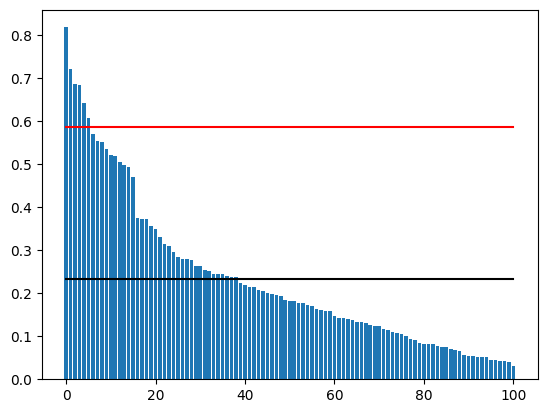

In [64]:
weights = sorted(sentence_weights.values(), reverse=True)
x = [i for i in range(len(weights))]
y = [avg_weight]*len(weights)
weight_scalar = 2.5

plt.bar(x,weights)
plt.plot(y, c="k")
plt.plot(list(map(lambda z:z*weight_scalar, y)), c="r")
plt.show()

In [65]:
print(len([weight for weight in weights if weight > avg_weight * weight_scalar]))

6


In [36]:
print_dict_ordered_on_keys(sentence_weights)

{'Other DisclosuresTable 1 : 3i -New Estimates123/06/2022 e30/09/2022 e31/03/2023 e31/03/2024 e\nJ.P. Morgan is a marketing name for investment banking businesses of JPMorgan Chase & Co. and its subsidiaries and affiliates worldwide.': 0.8186777782451211, 'We add this to our model as an unrealised gain in FY H1 and a realised gain in FY H2 and, taking into account carry, we estimate that it increases our live NAVe by 14pps from 1359.4pps to 1373.4pps, or 1%.': 0.7212967074507889, 'For all research material available on a particular stock, please contact your sales representative.Any long form nomenclature for references to China; Hong Kong; Taiwan; and Macau within this research material are Mainland China; Hong Kong SAR (China); Taiwan (China); and Macau SAR (China).': 0.6860258083239894, 'Most interest rate risk is hedged at the underlying company level, while 3i itself has long term fixed rate financing (£375m fixed at 5.75% to 2032 and £400m fixed at 3.75% to 2040).': 0.68407575173

In [17]:
@log_time
def calculate_idf_for_corpus(root_folder_path: Path) -> tuple[dict[str, int], dict[str, float], int]:
    """
    calculates the idf of terms from all .txt files beneath the folder path given

    Args:
        root_folder_path: the Path object to the folder that contains the txt files to be analyzed

    Returns:
        A tuple of 3 objects containing:
        1. A dictionary from term to inverse document frequency
        2. A dictionary from term to count of number of documents it occurs in
        3. The count of number of documents analyzed
    """
    term_doc_count = dict()
    num_docs = 0
    for filepath in root_folder_path.rglob("*.txt"):
        if filepath.is_file():
            num_docs += 1
            with open(filepath, "r", encoding="utf-8") as f:
                document = f.read()
            doc_tokens = preprocess_text(document, as_list=False)
            for token in doc_tokens:
                if token in term_doc_count:
                    term_doc_count[token] += 1
                else:
                    term_doc_count[token] = 1

    idf = {term: np.log(num_docs / frequency) for term, frequency in term_doc_count.items()}
    return idf, term_doc_count, num_docs

In [18]:
root_folder_path = Path("../../../FilestoreRepo/FTSE100Info/txtReports/3i_group")
idf, term_count, num_docs = calculate_idf_for_corpus(root_folder_path)

Function calculate_idf_for_corpus Took 0:00:04.438132


In [19]:
print_dict_ordered_on_keys(idf)

{'powder': 2.772588722239781, 'anniversari': 2.772588722239781, 'hatchley': 2.772588722239781, 'host': 2.772588722239781, 'withdrawn': 2.772588722239781, 'restart': 2.772588722239781, 'frame': 2.772588722239781, 'justifi': 2.772588722239781, 'perceiv': 2.772588722239781, 'eurofund': 2.772588722239781, 'julia': 2.772588722239781, 'reach': 2.772588722239781, 'zaimukyokuchoasia': 2.772588722239781, 'focal': 2.772588722239781, 'gradual': 2.772588722239781, 'ten23': 2.772588722239781, 'pilot': 2.772588722239781, '4338a27f44e32d6e7a0fd342f3cddc82': 2.772588722239781, 'situat': 2.772588722239781, 'meaning': 2.772588722239781, 'wilson': 2.772588722239781, 'sander': 2.772588722239781, 'overweightamundi': 2.772588722239781, 'lengthen': 2.772588722239781, 'positivebanca': 2.772588722239781, 'crisi': 2.772588722239781, '3914': 2.772588722239781, '1735': 2.772588722239781, 'salesforc': 2.772588722239781, 'demograph': 2.772588722239781, 'poland': 2.772588722239781, 'aggress': 2.772588722239781, '241

In [20]:
@log_time
def calculate_idf_for_corpus_parrallel(root_folder_path: Path, max_num_processes: int = 16) -> tuple[
    dict[str, int], dict[str, float], int]:
    """
    calculates the idf of terms from all .txt files beneath the folder path given in parralell

    Args:
        root_folder_path: the Path object to the folder that contains the txt files to be analyzed

    Returns:
        A tuple of 3 objects containing:
        1. A dictionary from term to inverse document frequency
        2. A dictionary from term to count of number of documents it occurs in
        3. The count of number of documents analyzed
    """
    term_doc_count = dict()
    filepaths = [filepath for filepath in root_folder_path.rglob("*.txt") if filepath.is_file()]
    num_docs = len(filepaths)
    num_processes = min(max_num_processes, num_docs)

    if num_processes > 0:
        with Pool(num_processes) as pool:
            doc_tokens_list: list[dict[str, int]] = pool.map(preprocess_text, filepaths)

    for doc_tokens in doc_tokens_list:
        for token in doc_tokens:
            if token in term_doc_count:
                term_doc_count[token] += 1
            else:
                term_doc_count[token] = 1

    idf = {term: np.log(num_docs / frequency) for term, frequency in term_doc_count.items()}
    return idf, term_doc_count, num_docs

In [ ]:
root_folder_path = Path("../../../FilestoreRepo/FTSE100Info/txtReports/3i_group")
idf, term_count, num_docs = calculate_idf_for_corpus_parrallel(root_folder_path)

In [ ]:
print_dict_ordered_on_keys(idf)

In [ ]:
def calculate_idf_for_corpus(root_):
    term_doc_count = dict()
    num_docs = 0
    for filepath in root_folder_path.rglob("*.txt"):
        print(f"{filepath.resolve()}")
        if filepath.is_file():
            num_docs += 1
            with open(filepath, "r", encoding="utf-8") as f:
                document = f.read()
            doc_tokens = preprocess_text(document, as_list=False)
            for token in doc_tokens:
                if token in term_doc_count:
                    term_doc_count[token] += 1
                else:
                    term_doc_count[token] = 1

    return {term: np.log(num_docs/frequency) for term, frequency in term_doc_count.items()}


In [ ]:
root_folder_path = Path("../../../FilestoreRepo/FTSE100Info/txtReports/3i_group")
idf = calculate_idf_for_corpus(root_folder_path)